# Managerial Accounting EDA

In [1]:
#!pip install basemap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
df = pd.read_csv('../data/double_entry_managerial_accounting.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
#Only use data from accounting period 2022
df = df[df['Date'].dt.year == 2022]

In [5]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66196 entries, 10 to 199997
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              66196 non-null  datetime64[ns]
 1   Account Number    66196 non-null  int64         
 2   Transaction Type  66196 non-null  object        
 3   Category          66196 non-null  object        
 4   Department        66196 non-null  object        
 5   Project           66196 non-null  object        
 6   Location          66196 non-null  object        
 7   Reference Number  66196 non-null  int64         
 8   Account           66196 non-null  object        
 9   Credit            66196 non-null  float64       
 10  Debit             66196 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 6.1+ MB
None


,Date,Account Number,Transaction Type,Category,Department,Project,Location,Reference Number,Account,Credit,Debit
10,2022-04-22 05:17:26,89512,Expense,Utilities,Marketing,Project D,New York,2938583,Expense Account,0.00,804.90
11,2022-04-22 05:17:26,89512,Expense,Utilities,Marketing,Project D,New York,2938583,Cash,804.90,0.00
14,2022-06-16 02:51:17,30841,Expense,Utilities,HR,Project C,New York,4802189,Expense Account,0.00,309.06
15,2022-06-16 02:51:17,30841,Expense,Utilities,HR,Project C,New York,4802189,Cash,309.06,0.00
22,2022-10-16 22:50:43,32569,Expense,Utilities,HR,Project D,Chicago,6999666,Expense Account,0.00,921.49


In [6]:
print(df['Transaction Type'].unique())
print(df['Category'].unique())
print(df['Department'].unique())
print(df['Project'].unique())
print(df['Account'].unique())
print(df['Location'].unique())

['Expense' 'Liability Payment' 'Revenue' 'Asset Purchase']
['Utilities' 'Supplies' 'Salaries' 'Rent' 'Assets' 'Loans' 'Product Sales'
 'Royalties' 'Service Revenue']
['Marketing' 'HR' 'Finance' 'Sales']
['Project D' 'Project C' 'Project B' 'Project A']
['Expense Account' 'Cash' 'Asset Account' 'Revenue Account']
['New York' 'Chicago' 'Los Angeles' 'Houston']


## Transaction Category

### How many transactions are in each category?

<AxesSubplot:>

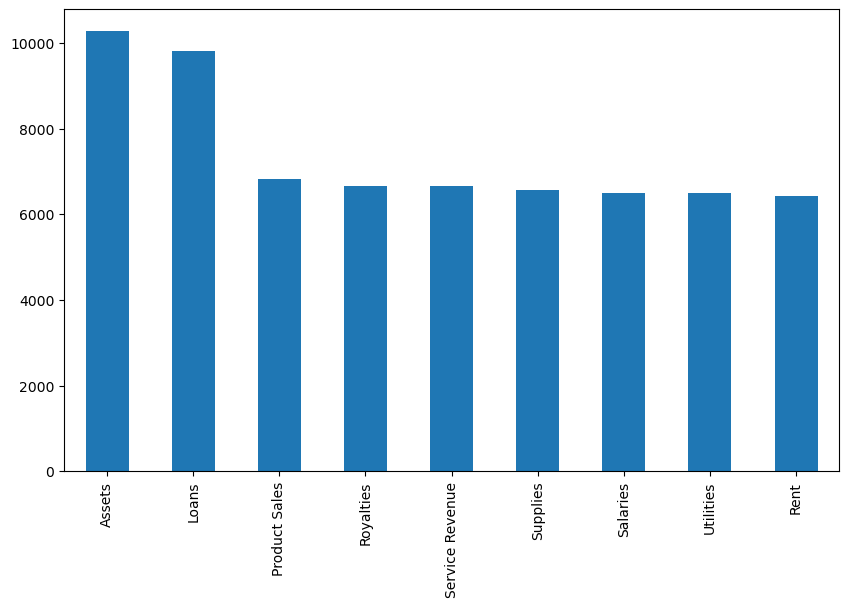

In [7]:
df['Category'].value_counts().plot(kind='bar', figsize=(10, 6))

### How does the transaction volume change month-to-month?

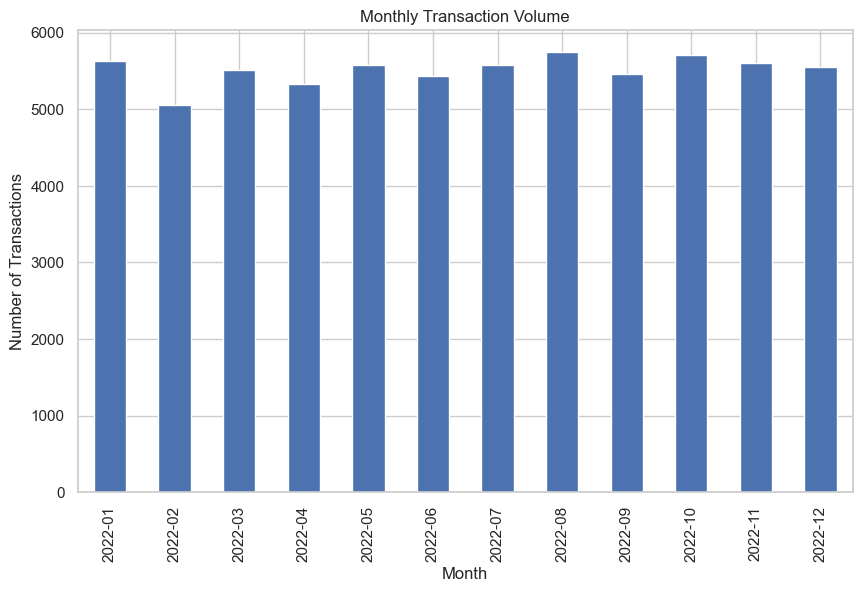

ANOVA Test Results
F-Value: 0.36663482369596123, P-Value: 0.9689377132359385
There is no statistically significant difference in transactions volume month-to-month.


In [34]:
transaction_volume = df.groupby(df['Date'].dt.to_period('M')).size()

transaction_volume.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

monthly_transactions = [df[df['Month'] == month]['Debit'] for month in df['Month'].unique()]
f_value, p_value = stats.f_oneway(*monthly_transactions)
print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in transactions volume month-to-month.")
else:
    print("There is no statistically significant difference in transactions volume month-to-month.")
df.reset_index(inplace=True)
df.drop(columns=['Month'], inplace=True)

### Histogram of transaction amounts by category

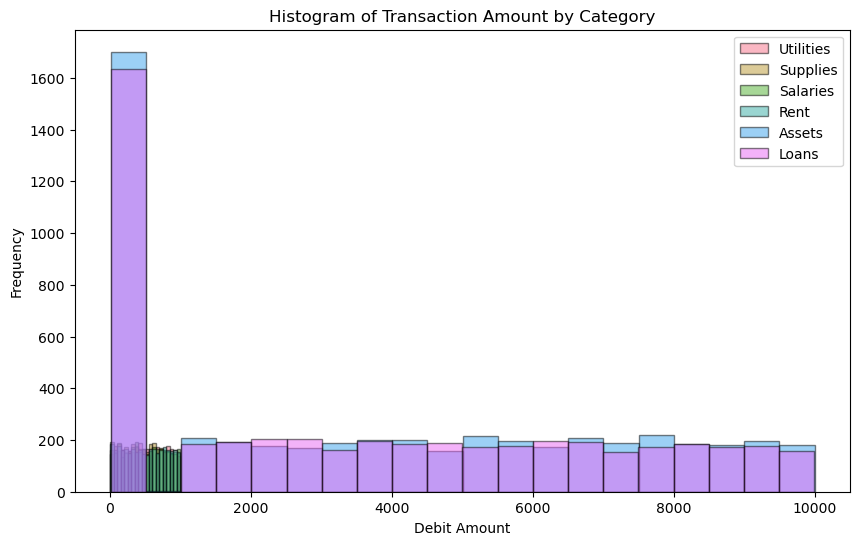

In [9]:
palette = sns.color_palette("husl")
plt.figure(figsize=(10, 6))

for category, color in zip(df.Category.unique(), palette):
    dept_df = df[(df['Category'] == category) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=category, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Amount by Category')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

### Further comparison of the distribution of transaction amounts by category

In [10]:
filtered_df = df[df['Debit'] > 0]
f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Category'] == 'Utilities']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Supplies']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Salaries']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Rent']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Assets']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Loans']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Product Sales']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Royalties']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Service Revenue']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of transaction amounts by category.")
    print("Post-Hoc Analysis (Tukey's HSD Test):")
    mc = MultiComparison(filtered_df['Debit'], filtered_df['Category'])
    result = mc.tukeyhsd() 
    print(result)
    # print("Significant Differences (Tukey's HSD Test):")
    # for res, reject in zip(result.summary().data[1:], result.reject):
    #     if reject:
    #         print(res[0], res[1])

else:
    print("There is no statistically significant difference in the distribution of transaction amounts by category.")

ANOVA Test Results
F-Value: 2025.9374549941474, P-Value: 0.0
There is a statistically significant difference in the distribution of transaction amounts by category.
Post-Hoc Analysis (Tukey's HSD Test):
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1          group2      meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------------
         Assets           Loans   -83.9873 0.4381  -205.0854    37.1109  False
         Assets   Product Sales -1228.2729    0.0 -1362.2522 -1094.2936   True
         Assets            Rent   -3269.53    0.0 -3405.9793 -3133.0807   True
         Assets       Royalties  -1204.273    0.0 -1339.2028 -1069.3431   True
         Assets        Salaries -3269.9007    0.0  -3405.833 -3133.9684   True
         Assets Service Revenue -1203.0829    0.0 -1338.1235 -1068.0423   True
         Assets        Supplies -3276.3425    0.0 -3411.9444 -3140.7405   True
       

## Transaction Analysis by Department

### Does transaction volume vary by department?

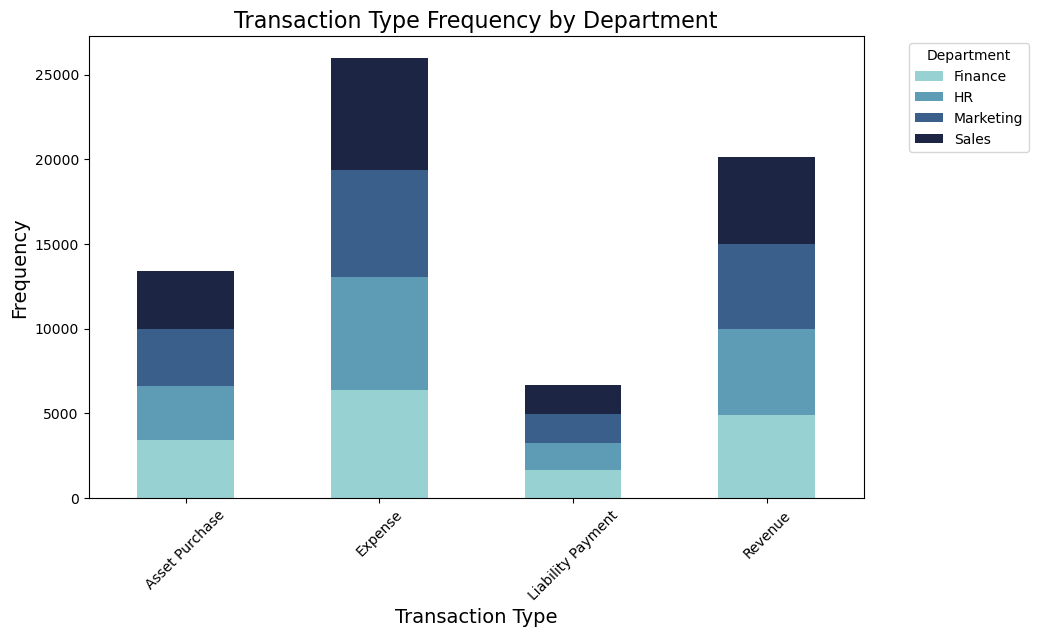

Chi-Square Test Results
Chi-Square Statistic: 27.553192735675253, P-Value: 0.0011323494923205586
There is a statistically significant relationship between Department and volume per Transaction Type.


In [11]:
grouped_data = df.groupby(['Transaction Type', 'Department']).size().unstack(fill_value=0)
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Department.nunique())
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=palette)
plt.title('Transaction Type Frequency by Department', fontsize=16)
plt.xlabel('Transaction Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

contingency_table = pd.crosstab(df['Department'], df['Transaction Type'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

if p < 0.05:
    print("There is a statistically significant relationship between Department and volume per Transaction Type.")
else:
    print("There is no statistically significant relationship between Department and volume per Transaction Type.")

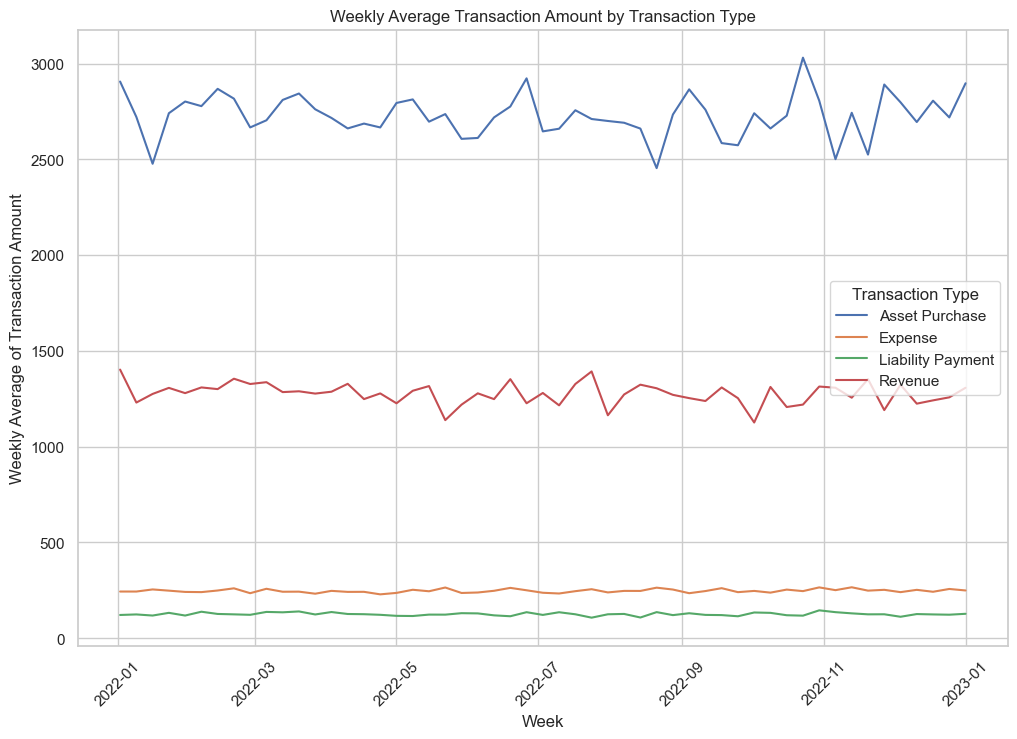

In [12]:
df.set_index('Date', inplace=True)

weekly_avg_by_category = df.groupby('Transaction Type').resample('W')['Debit'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=weekly_avg_by_category, x='Date', y='Debit', hue='Transaction Type')

plt.title('Weekly Average Transaction Amount by Transaction Type')
plt.xlabel('Week')
plt.ylabel('Weekly Average of Transaction Amount')
plt.xticks(rotation=45)
plt.show()
df.reset_index(inplace=True)

## Debit and Credit Analysis per Account
**Debit**: An accounting entry that either increases an asset or expense account, or decreases a liability or equity account.<br>
**Credit**: An accounting entry that either increases a liability or equity account, or decreases an asset or expense account.

*Per [AccountingTools](https://www.accountingtools.com/articles/debits-and-credits)*

In [13]:
account_totals = df.groupby('Account').agg({'Debit': 'sum', 'Credit': 'sum'})

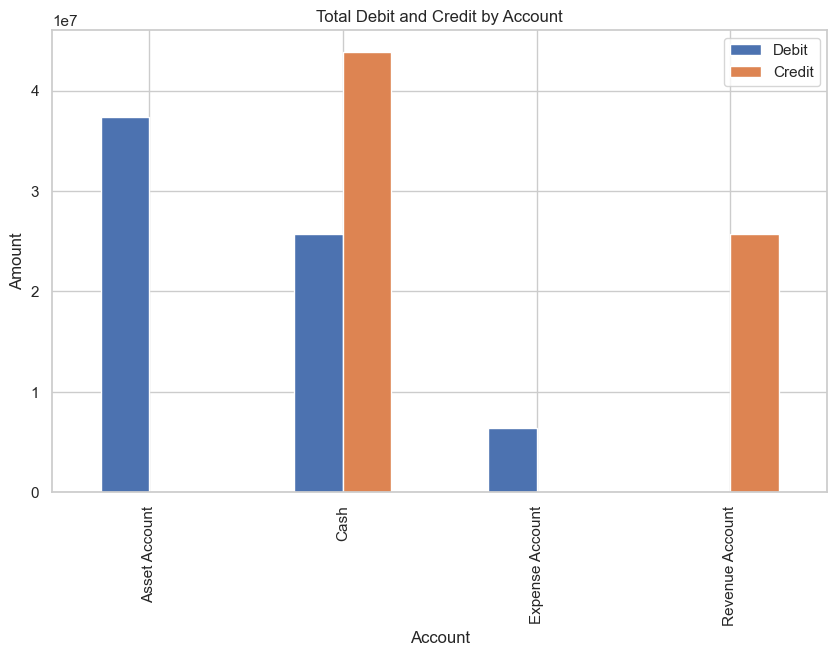

In [14]:
account_totals.sort_values(by='Debit', ascending=False, inplace=True)
account_totals.plot(kind='bar', figsize=(10, 6))
plt.title('Total Debit and Credit by Account')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

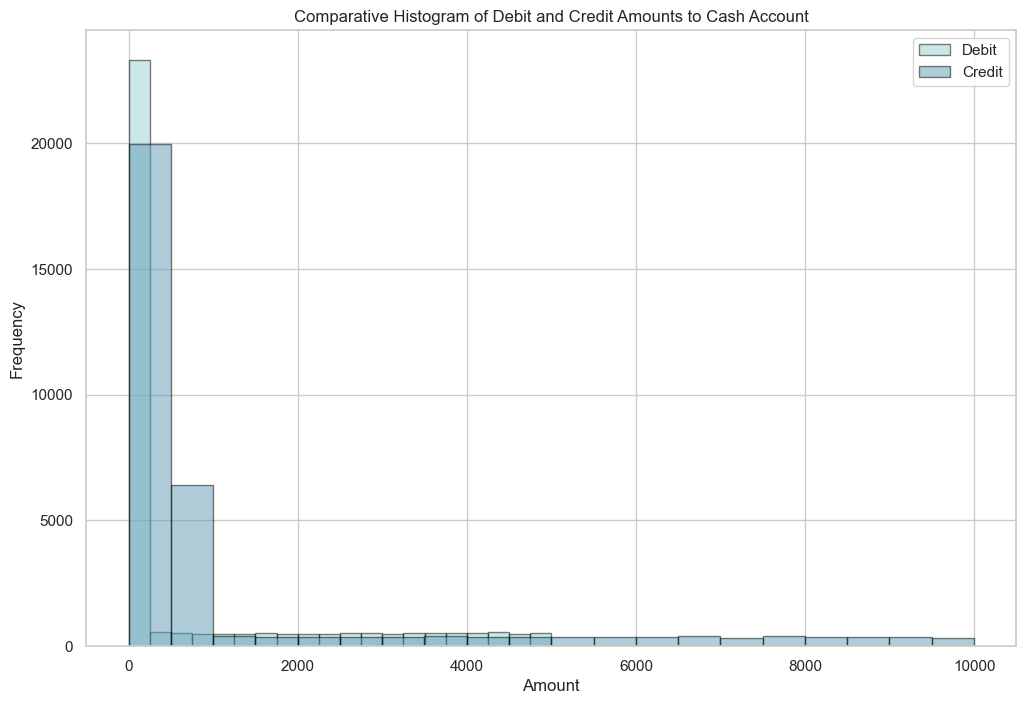

In [15]:
cash_account_df = df[df['Account'] == 'Cash']
plt.figure(figsize=(12, 8))
plt.hist(cash_account_df['Debit'], bins=20, alpha=0.5, label='Debit', color=palette[0], edgecolor='black')
plt.hist(cash_account_df['Credit'], bins=20, alpha=0.5, label='Credit', color=palette[1], edgecolor='black')
plt.legend()
plt.title('Comparative Histogram of Debit and Credit Amounts to Cash Account')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

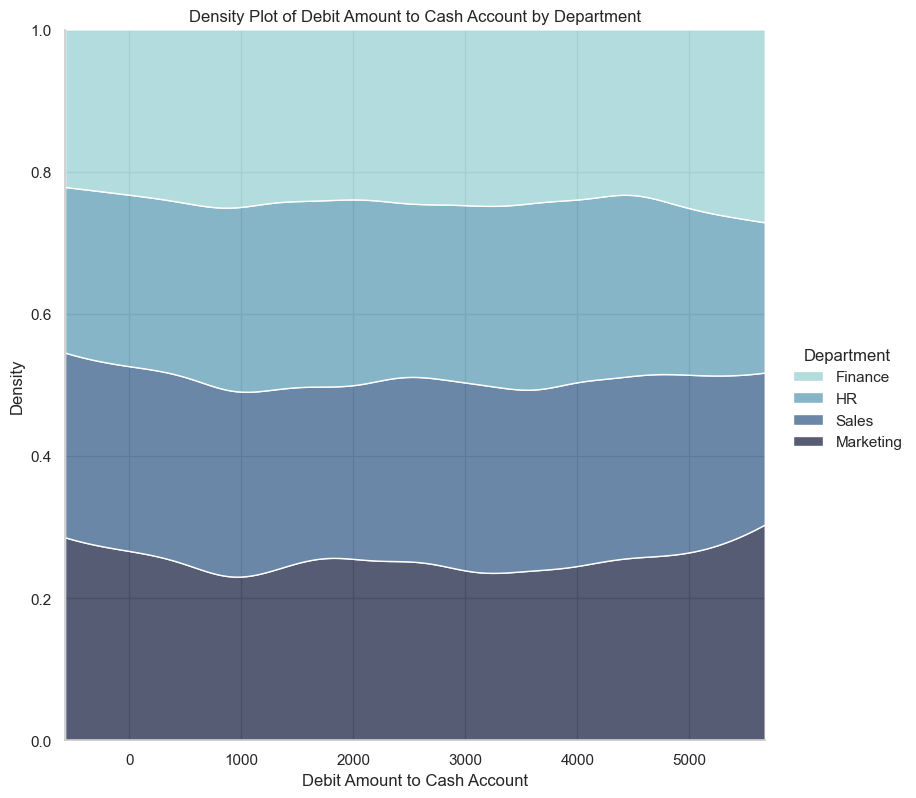

In [16]:
debits_df = df[(df['Debit'] > 0) & (df['Account'] == 'Cash')]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Density Plot of Debit Amount to Cash Account by Department')
plt.xlabel('Debit Amount to Cash Account')
plt.ylabel('Density')
plt.show()

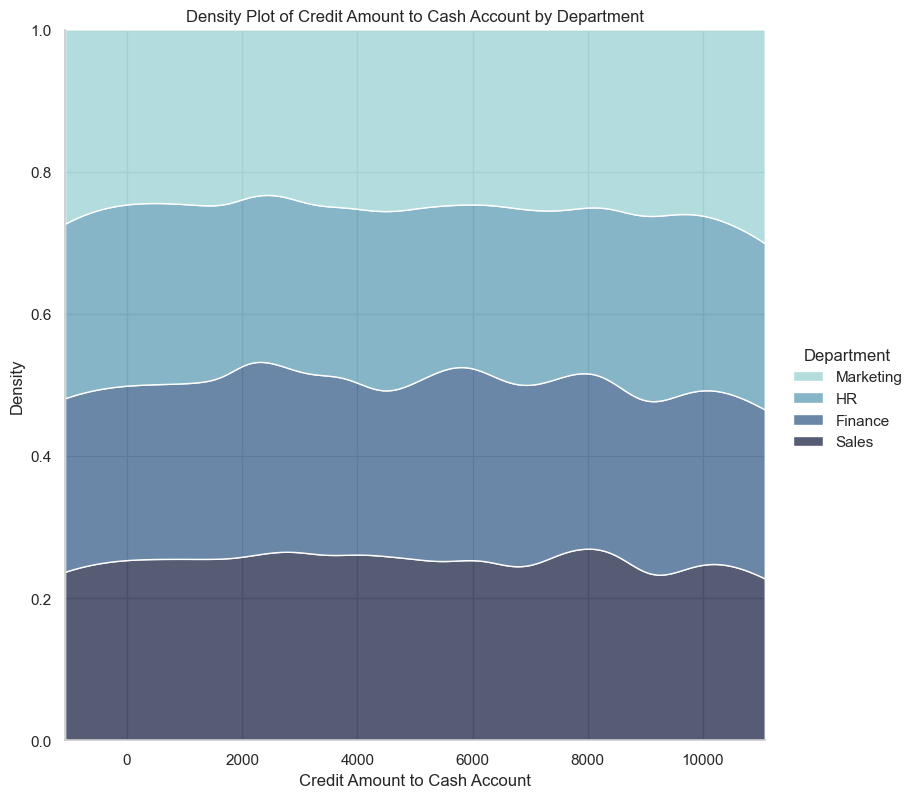

In [17]:
debits_df = df[(df['Credit'] > 0) & (df['Account'] == 'Cash')]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Credit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Density Plot of Credit Amount to Cash Account by Department')
plt.xlabel('Credit Amount to Cash Account')
plt.ylabel('Density')
plt.show()

### What is the average transaction amount for each category?

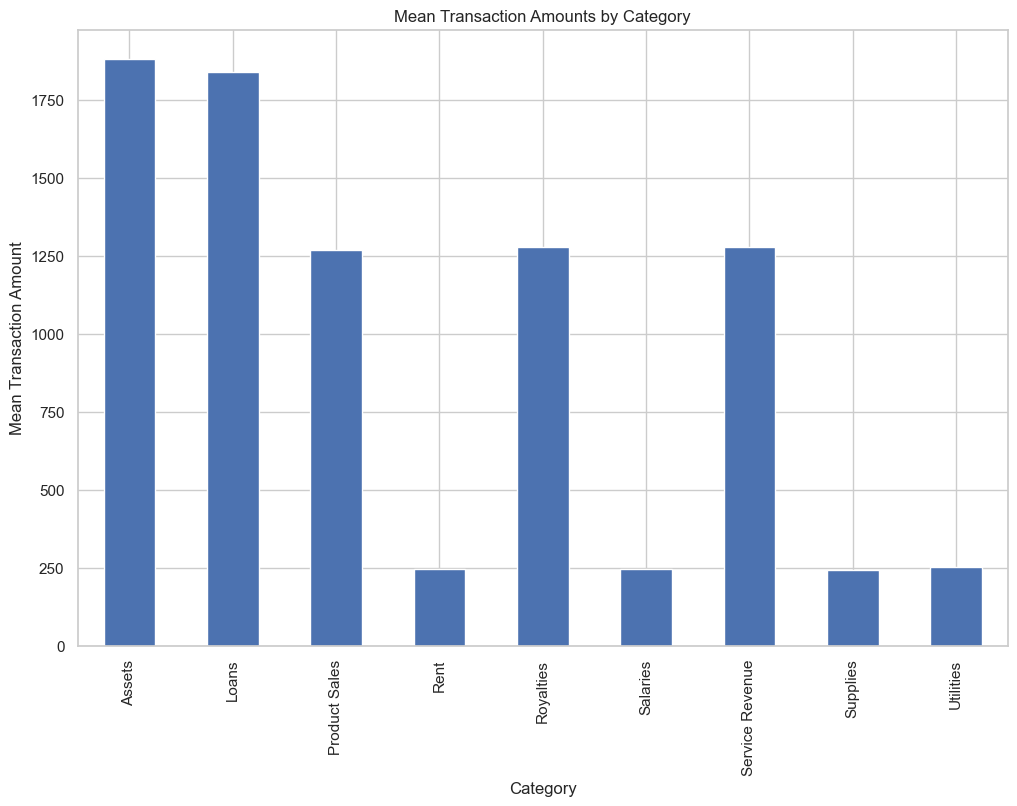

In [18]:
df.groupby('Category')['Debit'].mean().plot(kind='bar', figsize=(12, 8))
plt.title('Mean Transaction Amounts by Category')
plt.ylabel('Mean Transaction Amount')
plt.xlabel('Category')
plt.show()

## Departmental Transaction Analysis

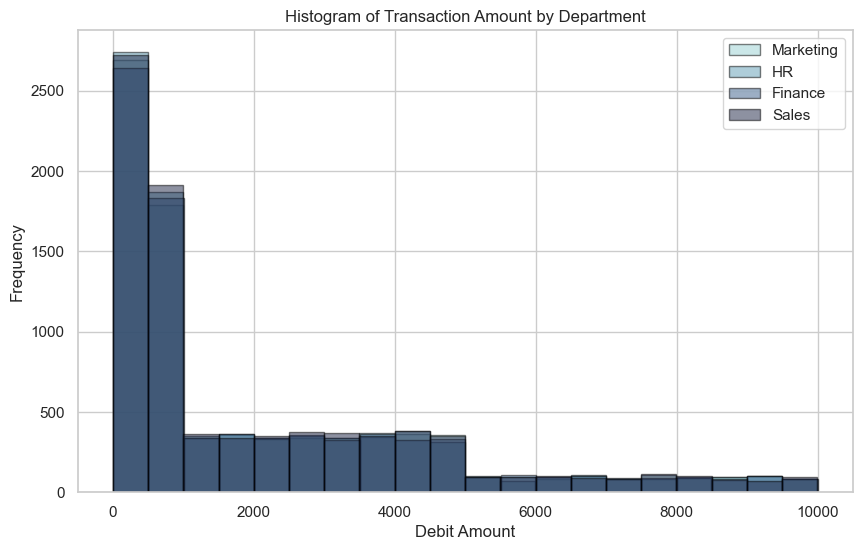

In [19]:
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Department.nunique())
plt.figure(figsize=(10, 6))

for category, color in zip(df.Department.unique(), palette):
    dept_df = df[(df['Department'] == category) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=category, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Amount by Department')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

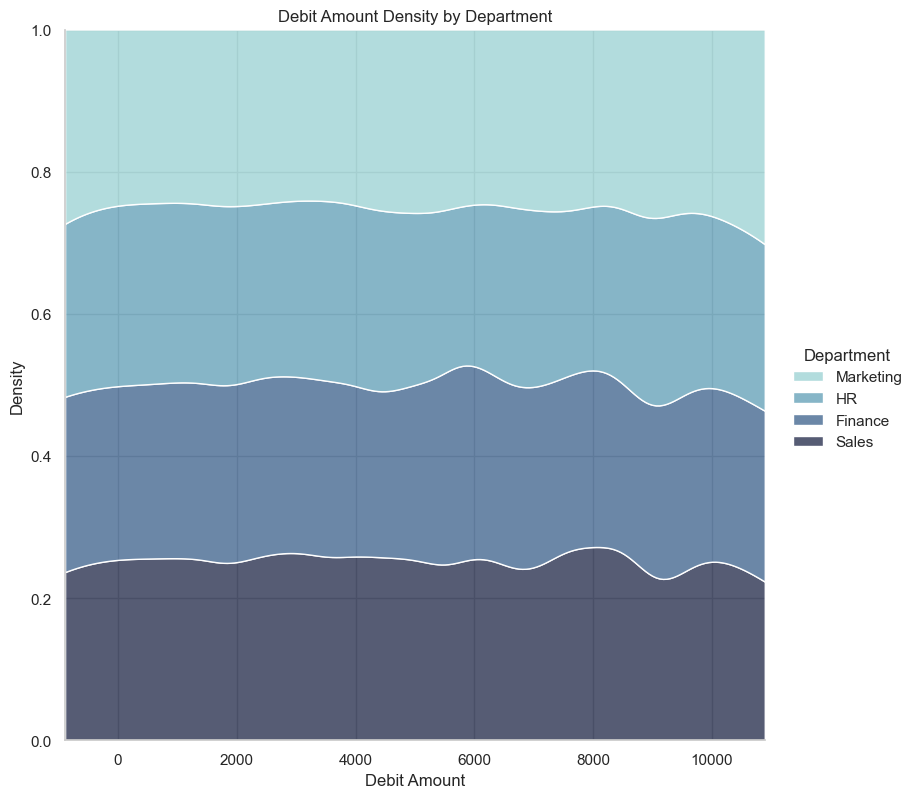

In [20]:
debits_df = df[df['Debit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Debit Amount Density by Department')
plt.xlabel('Debit Amount')
plt.ylabel('Density')
plt.show()

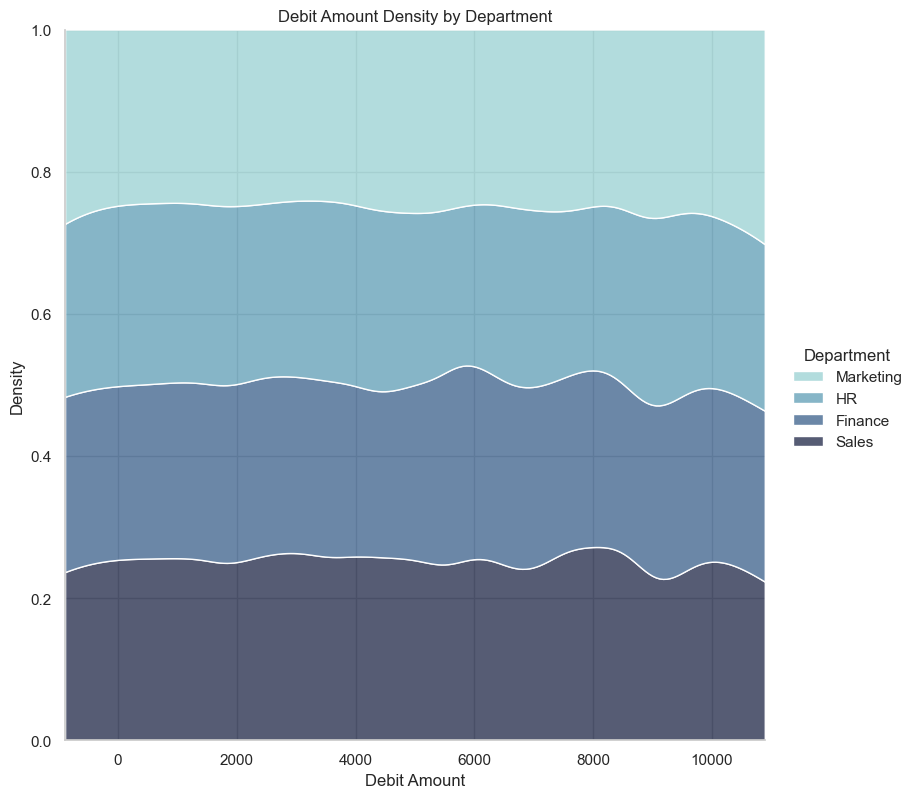

In [21]:
debits_df = df[df['Debit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Debit Amount Density by Department')
plt.xlabel('Debit Amount')
plt.ylabel('Density')
plt.show()

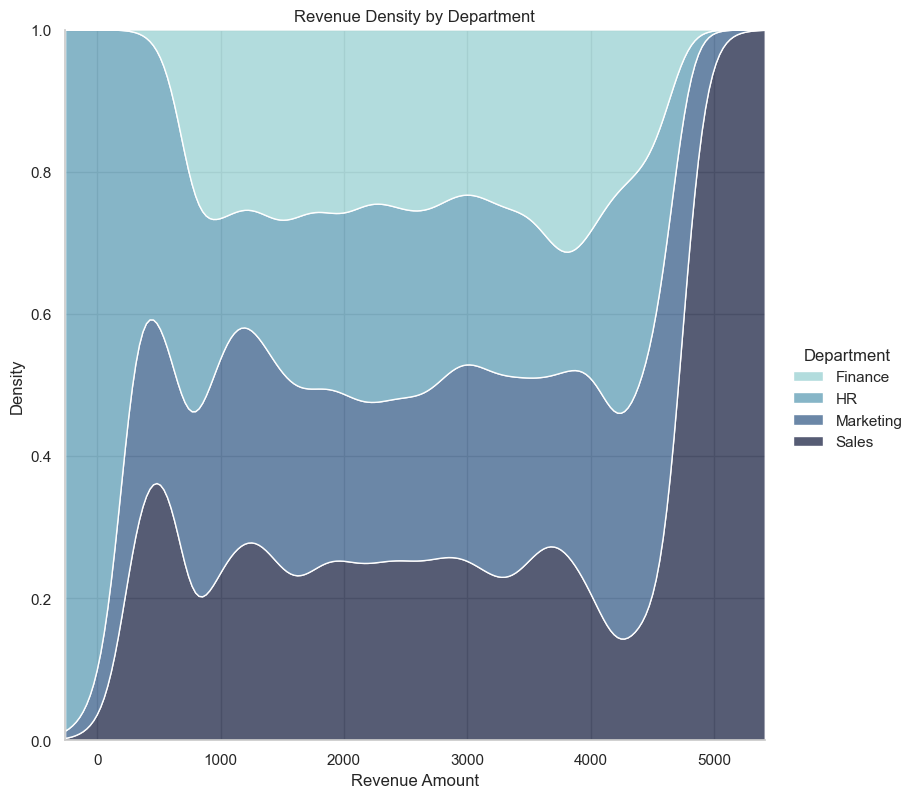

In [22]:
expense_df = df[(df['Transaction Type'] == 'Revenue') & (df['Debit'] > 0)]
expense_df.set_index('Date', inplace=True)
weekly_expense = expense_df.groupby('Department').resample('D').mean()

sns.set_theme(style="whitegrid")
g = sns.displot(data=weekly_expense, x='Debit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)

plt.title('Revenue Density by Department')
plt.xlabel('Revenue Amount')
plt.ylabel('Density')
plt.show()

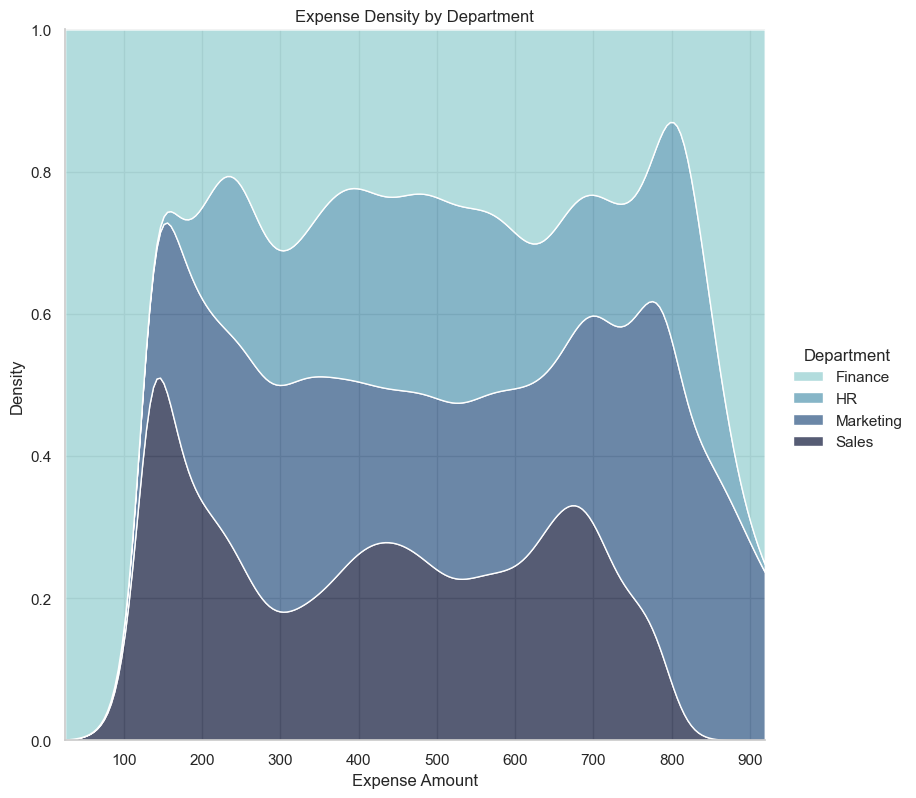

In [23]:
expense_df = df[(df['Transaction Type'] == 'Expense') & (df['Debit'] > 0)]
expense_df.set_index('Date', inplace=True)
weekly_expense = expense_df.groupby('Department').resample('D').mean()

sns.set_theme(style="whitegrid")
g = sns.displot(data=weekly_expense, x='Debit', hue='Department', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)

plt.title('Expense Density by Department')
plt.xlabel('Expense Amount')
plt.ylabel('Density')
plt.show()

### How is daily mean transaction amount distributed across different accounts?

#### Density

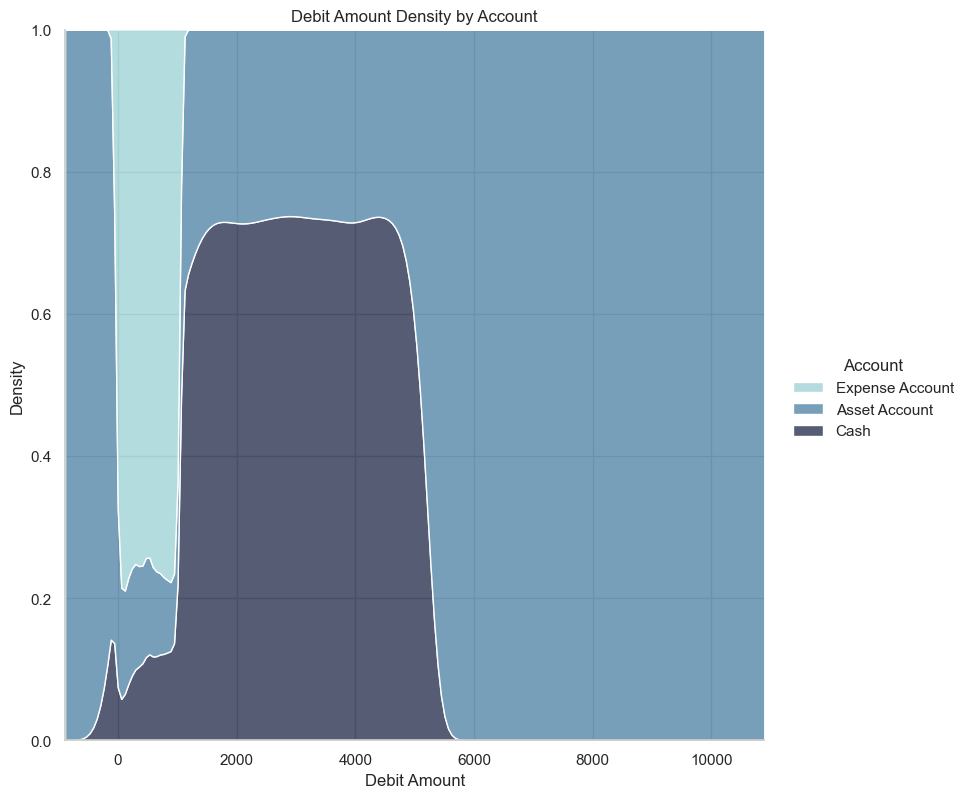

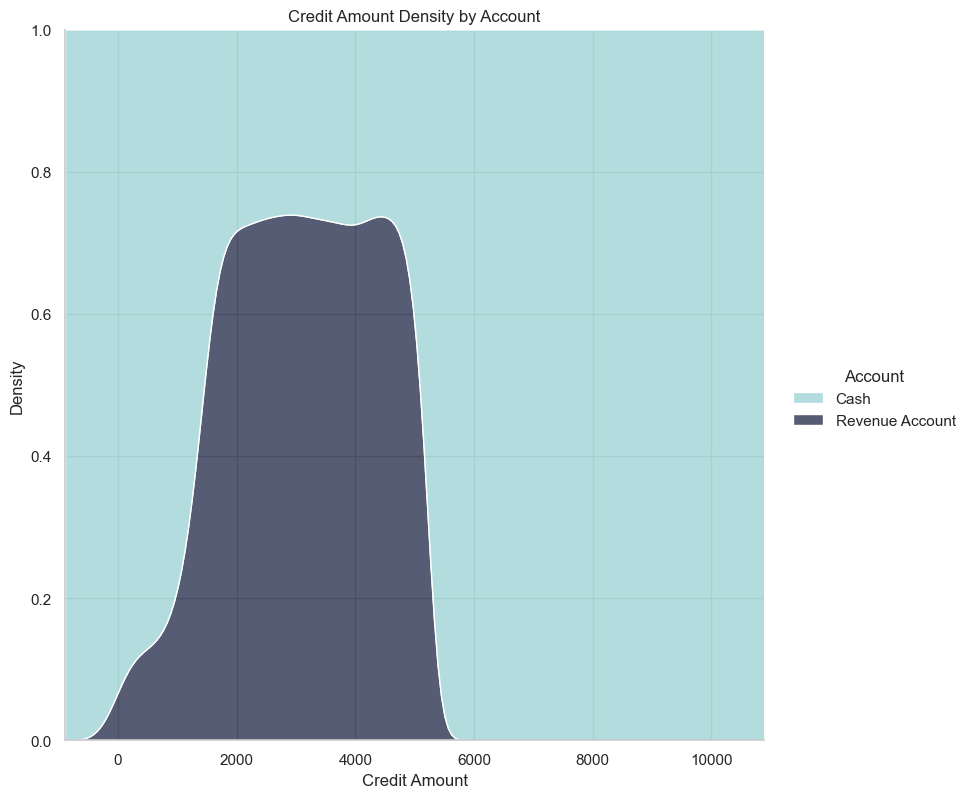

In [24]:
debits_df = df[df['Debit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Account', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Debit Amount Density by Account')
plt.xlabel('Debit Amount')
plt.ylabel('Density')
plt.show()

debits_df = df[df['Credit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Credit', hue='Account', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Credit Amount Density by Account')
plt.xlabel('Credit Amount')
plt.ylabel('Density')
plt.show()

### Distribution

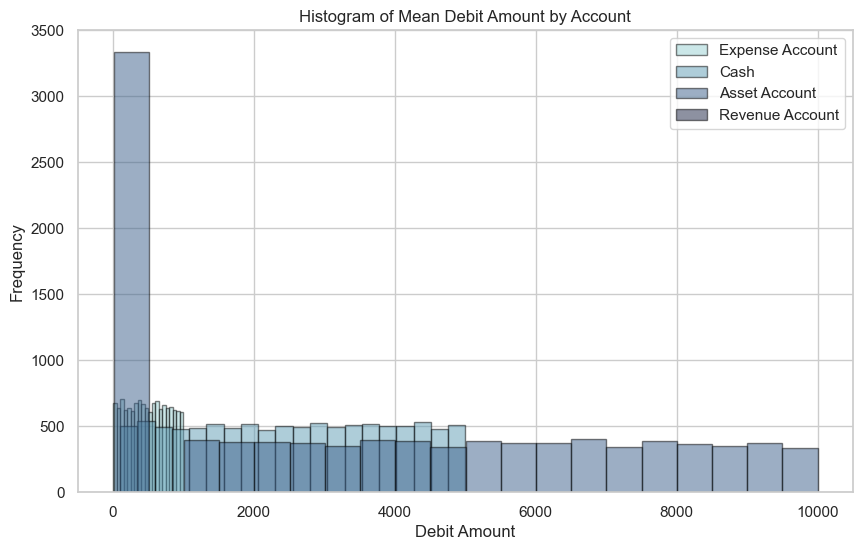

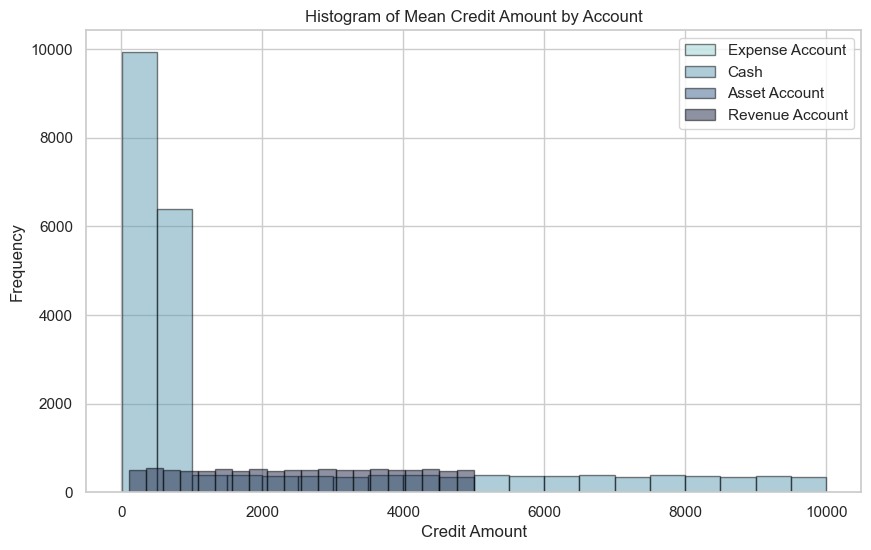

In [25]:
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Account.nunique())
plt.figure(figsize=(10, 6))

for acct, color in zip(df.Account.unique(), palette):
    acct_df = df[(df['Account'] == acct) & (df['Debit'] > 0)]
    plt.hist(acct_df['Debit'], bins=20, alpha=0.5, label=acct, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Mean Debit Amount by Account')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Account.nunique())
plt.figure(figsize=(10, 6))

for acct, color in zip(df.Account.unique(), palette):
    acct_df = df[(df['Account'] == acct) & (df['Credit'] > 0)]
    plt.hist(acct_df['Credit'], bins=20, alpha=0.5, label=acct, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Mean Credit Amount by Account')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.show()

In the above two plots, all four departments seem to have a similar distribution of transaction amounts. We will test this observation using the ANOVA test.

In [26]:
filtered_df = df[df['Debit'] > 0]

f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Department'] == 'Marketing']['Debit'],
                                   filtered_df[filtered_df['Department'] == 'HR']['Debit'],
                                   filtered_df[filtered_df['Department'] == 'Sales']['Debit'],
                                   filtered_df[filtered_df['Department'] == 'Finance']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the transaction amount by department.")
else:
    print("There is no statistically significant difference in the transaction amount by department")

ANOVA Test Results
F-Value: 0.7088245921754946, P-Value: 0.5465828034597837
There is no statistically significant difference in the transaction amount by department


## Geographic Analysis

### Do transaction amounts vary by location?

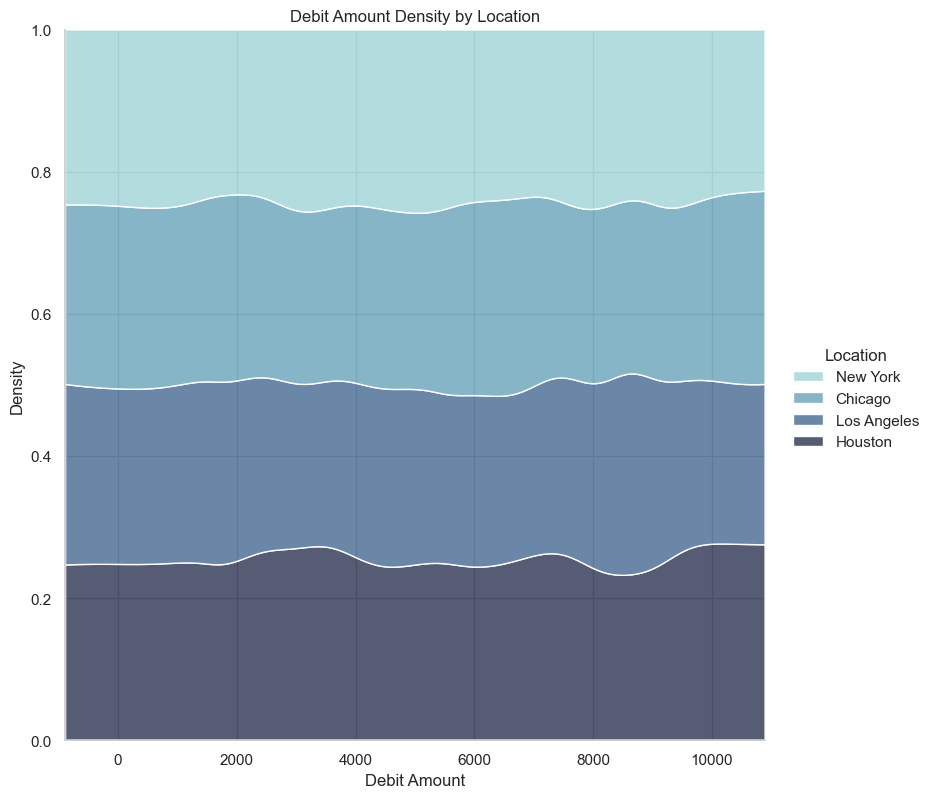

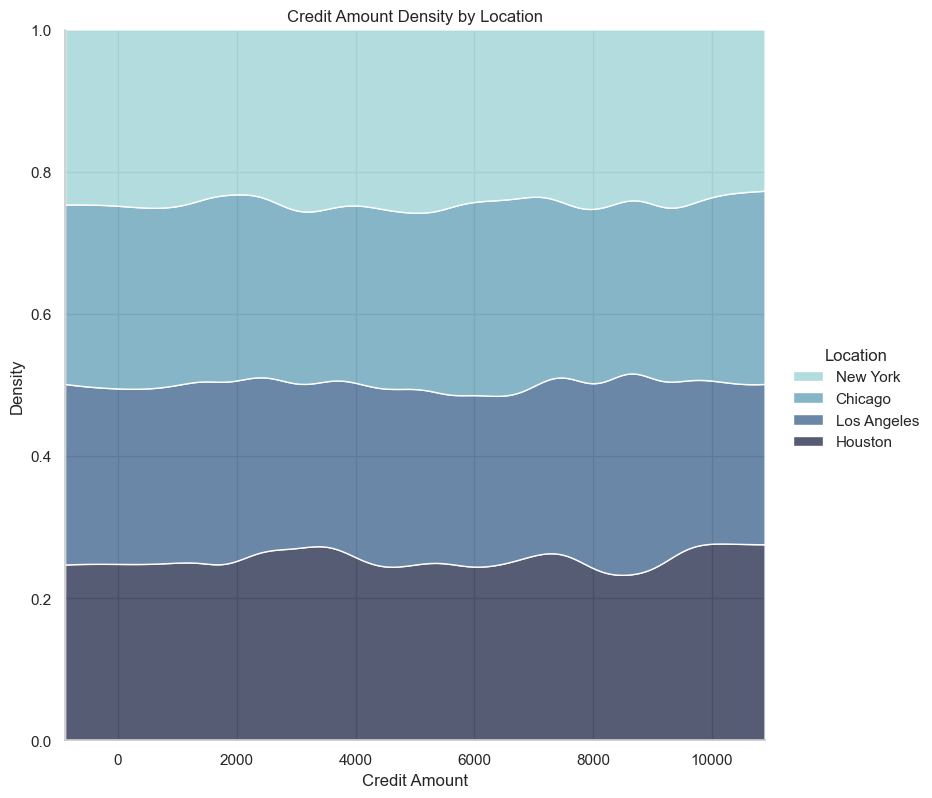

In [27]:
debits_df = df[df['Debit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Location', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Debit Amount Density by Location')
plt.xlabel('Debit Amount')
plt.ylabel('Density')
plt.show()

debits_df = df[df['Credit'] > 0]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Credit', hue='Location', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Credit Amount Density by Location')
plt.xlabel('Credit Amount')
plt.ylabel('Density')
plt.show()

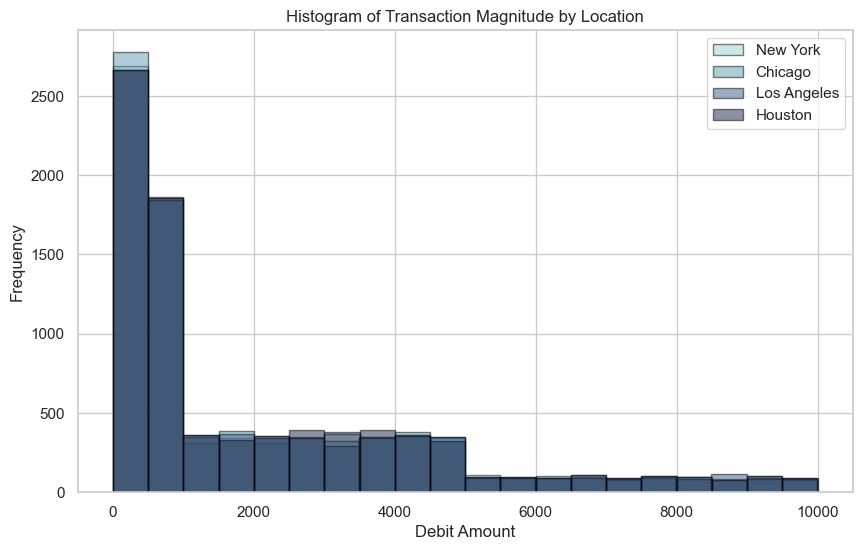

In [29]:
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Location.nunique())
plt.figure(figsize=(10, 6))

for dept, color in zip(df.Location.unique(), palette):
    dept_df = df[(df['Location'] == dept) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=dept, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Magnitude by Location')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

In [30]:
filtered_df = df[df['Debit'] > 0]

f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Location'] == 'New York']['Debit'],
                                   filtered_df[filtered_df['Location'] == 'Chicago']['Debit'],
                                   filtered_df[filtered_df['Location'] == 'Los Angeles']['Debit'],
                                   filtered_df[filtered_df['Location'] == 'Houston']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the transaction amount by location.")
else:
    print("There is no statistically significant difference in the transaction amount by location")

ANOVA Test Results
F-Value: 0.24935478162246016, P-Value: 0.8618439600157811
There is no statistically significant difference in the transaction amount by location


### Is there a difference in transaction amounts per project between locations?

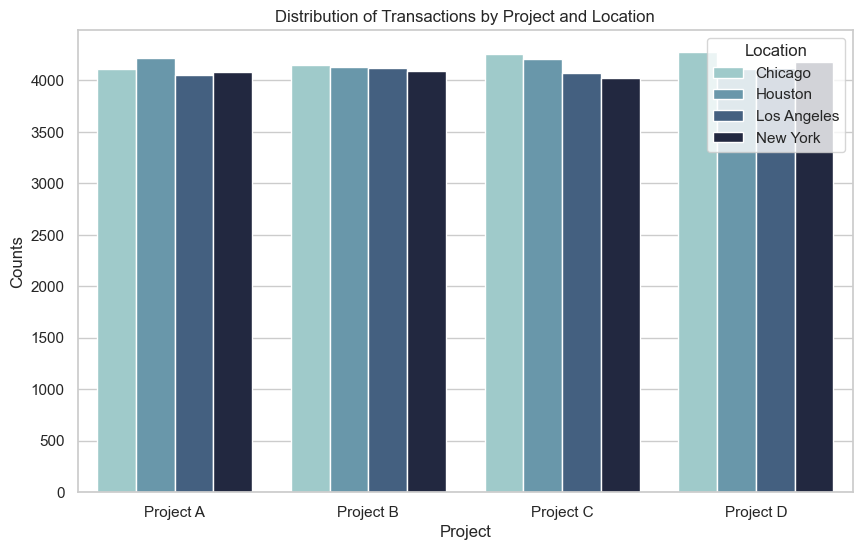

Chi-square Test Results:
Chi-square statistic: 9.261668073026334
P-value: 0.4134790905759874
Degrees of freedom: 9
There is no statistically significant relationship between Location and Project in terms of transaction frequency.


In [31]:
city_counts = df.groupby(['Project', 'Location']).size().reset_index(name='Counts')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Project', y='Counts', hue='Location', data=city_counts, palette="ch:rot=-.25,hue=1,light=.75")

plt.title('Distribution of Transactions by Project and Location')
plt.show()

contingency_table = pd.crosstab(df['Location'], df['Project'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test Results:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Location and Project in terms of transaction frequency.")
else:
    print("There is no statistically significant relationship between Location and Project in terms of transaction frequency.")

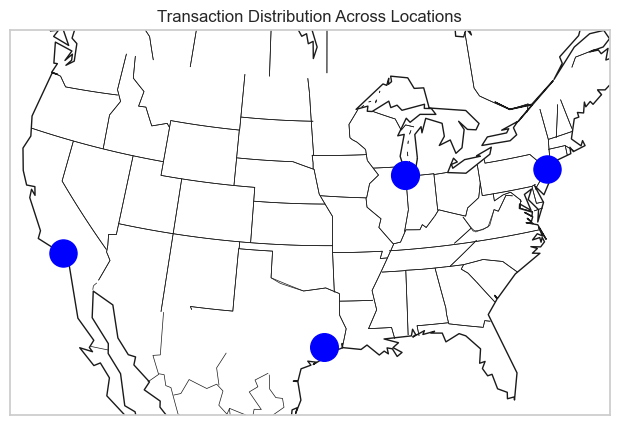

In [32]:
city_counts = df['Location'].value_counts()

# Hardcode city coordinates
coordinates = {
    'Houston': (29.7604, -95.3698),
    'Los Angeles': (34.0522, -118.2437),
    'New York': (40.7128, -74.0060),
    'Chicago': (41.8781, -87.6298)
}

plt.figure(figsize=(10, 5))
map = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
              projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

map.drawcoastlines()
map.drawstates()

for city, count in city_counts.items():
    x, y = map(coordinates[city][1], coordinates[city][0])
    map.plot(x, y, marker='o', color='Blue', markersize=count / max(city_counts) * 20)

plt.title('Transaction Distribution Across Locations')
plt.show()